In [1]:
# All purpose library
import pandas as pd
import numpy as np

# Preprocessing library
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# ML library
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Performance metrics library
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, classification_report

# Visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# Ignoring Warning during trainings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/cities.csv') # reading the Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67161 entries, 0 to 67160
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        67161 non-null  int64  
 1   App.                        67161 non-null  object 
 2   Taxon                       67161 non-null  object 
 3   Class                       46937 non-null  object 
 4   Order                       67104 non-null  object 
 5   Family                      66700 non-null  object 
 6   Genus                       65702 non-null  object 
 7   Importer                    67090 non-null  object 
 8   Exporter                    66588 non-null  object 
 9   Origin                      25643 non-null  object 
 10  Importer reported quantity  31866 non-null  float64
 11  Exporter reported quantity  44021 non-null  float64
 12  Term                        67161 non-null  object 
 13  Unit                        640

Text(0.5, 1.0, 'Amount of each the different classes')

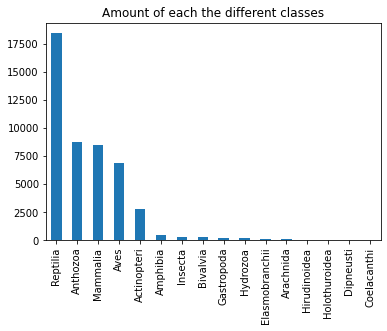

In [4]:
df['Class'].value_counts().plot(kind='bar')
plt.title("Amount of each the different classes")

Text(0.5, 1.0, 'Quantity Imported by class')

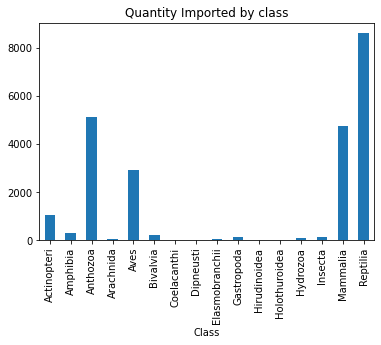

In [5]:
df_qty_imported_by_class = df.groupby(['Class'])['Importer reported quantity'].count().plot(kind='bar')
plt.title('Quantity Imported by class')

Text(0.5, 1.0, 'Quantity Exported by class')

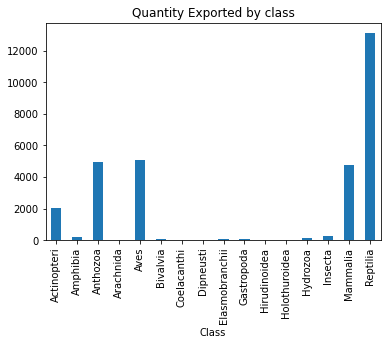

In [6]:
df_qty_exported_by_class = df.groupby(['Class'])['Exporter reported quantity'].count().plot(kind='bar')
plt.title('Quantity Exported by class')

In [7]:
df.isna().sum()

Year                              0
App.                              0
Taxon                             0
Class                         20224
Order                            57
Family                          461
Genus                          1459
Importer                         71
Exporter                        573
Origin                        41518
Importer reported quantity    35295
Exporter reported quantity    23140
Term                              0
Unit                          60759
Purpose                        6059
Source                          544
dtype: int64

Text(0.5, 1.0, 'Quantity Imported by App.')

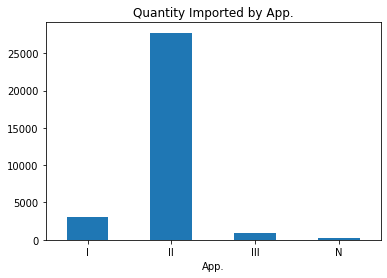

In [8]:
df_qty_imported_by_app = df.groupby(['App.'])['Importer reported quantity'].count().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Quantity Imported by App.')

In [9]:
df['App.'].value_counts()

II     59253
I       5976
III     1739
N        193
Name: App., dtype: int64

In [10]:
# Since App. value N is not part of the documentation and of the lowest cardinality, all observation with
# it will be removed
df = df[df['App.'] !='N']

In [11]:
# Remove the missing values in Importer/Exporter reported quantity
df = df[~df['Importer reported quantity'].isna() & ~df['Exporter reported quantity'].isna()]

In [12]:
df.isna().sum()

Year                             0
App.                             0
Taxon                            0
Class                         1455
Order                            1
Family                          22
Genus                           63
Importer                         0
Exporter                       161
Origin                        5081
Importer reported quantity       0
Exporter reported quantity       0
Term                             0
Unit                          8075
Purpose                          0
Source                           0
dtype: int64

In [13]:
df1 = df.drop(columns=['Purpose', 'Year', 'Taxon', 'Class', 'Origin', 'Term', 'Unit', 'Family', 'Genus', 'Order', 'Importer', 'Exporter'])

In [14]:
df1.isna().sum()

App.                          0
Importer reported quantity    0
Exporter reported quantity    0
Source                        0
dtype: int64

In [15]:
# Appendix I species are those whose trade threatens them with extinction
# Appendix II species are those not threatened with extinction, but whose trade is nevertheless detrimental
# Appendix III animals are those submitted to CITES by member states as a control mechanism

df1['App.'].value_counts()

II     7680
I       917
III     129
Name: App., dtype: int64

In [16]:
# For our work we are not interested in Appendix III animals, so we will remove their observations
df1 = df1[~(df1['App.'] == 'III')]
df1['App.'].value_counts()

II    7680
I      917
Name: App., dtype: int64

In [17]:
df_I = df1[df1['App.'] == 'I']
df_II = df1[df1['App.'] == 'II'].sample(1000)

data_df = pd.concat([df_I, df_II])

In [18]:
data_df = sklearn.utils.shuffle(data_df)
data_df = data_df.reset_index(drop=True)
data_df.shape

(1917, 4)

In [19]:
data_df['App.'].value_counts()

II    1000
I      917
Name: App., dtype: int64

In [20]:
# Specify the features and target
x = data_df.drop(columns='App.')
y = data_df['App.']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.2)
y_train.value_counts()

II    809
I     724
Name: App., dtype: int64

In [21]:
categorical = ['Source']
numerical = ['Importer reported quantity', 'Exporter reported quantity']

### Feature Engineering

In [22]:
# Scaling and transforming of the training and the test data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[numerical])
x_train_scaled = pd.DataFrame(x_train_scaled, columns=numerical)

x_test = x_test.reset_index(drop=True)
x_test_scaled = scaler.transform(x_test[numerical])
x_test_scaled = pd.DataFrame(x_test_scaled, columns=numerical)

In [23]:
# Encode categorical features are one-hot encoded using OneHotEncoder(set sparse_output to false), 
# convert the output back to a dataframe and put back the column names
encoder = OneHotEncoder(sparse=False)
x_train_encoded = encoder.fit_transform(x_train[categorical])
x_train_encoded = pd.DataFrame(x_train_encoded, columns=encoder.get_feature_names_out())

x_test_encoded = encoder.transform(x_test[categorical])
x_test_encoded = pd.DataFrame(x_test_encoded, columns=encoder.get_feature_names_out())

In [24]:
# Combine scaled numerical and one-hot encoded categorical features into train and test set dataframes
x_train_combine = pd.concat([x_train_encoded, x_train_scaled], axis=1)
x_test_combine = pd.concat([x_test_encoded, x_test_scaled], axis=1)

In [25]:
# Train a Random Forest classifier
RF_model = RandomForestClassifier(random_state=1)
RF_model.fit(x_train_combine, y_train)

# Prediction
y_pred = RF_model.predict(x_test_combine)
print (accuracy_score(y_test, y_pred))

# Model classification report
print(classification_report(y_test,y_pred))

0.8333333333333334
              precision    recall  f1-score   support

           I       0.86      0.79      0.83       193
          II       0.81      0.87      0.84       191

    accuracy                           0.83       384
   macro avg       0.84      0.83      0.83       384
weighted avg       0.84      0.83      0.83       384



In [26]:
# Train Extra Trees classifier
ET_model = ExtraTreesClassifier(random_state=1)
ET_model.fit(x_train_combine, y_train)

# Prediction
y_pred = ET_model.predict(x_test_combine)
print (accuracy_score(y_test, y_pred))

# Model classification report
print(classification_report(y_test,y_pred))

0.8255208333333334
              precision    recall  f1-score   support

           I       0.84      0.81      0.82       193
          II       0.82      0.84      0.83       191

    accuracy                           0.83       384
   macro avg       0.83      0.83      0.83       384
weighted avg       0.83      0.83      0.83       384



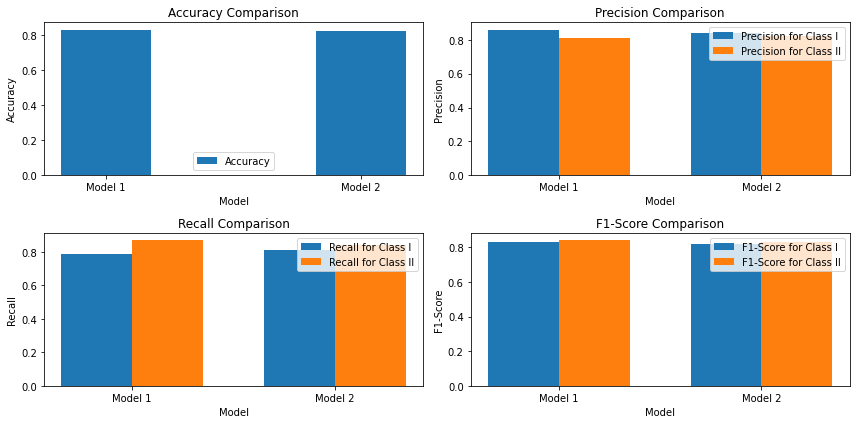

In [28]:
# Visualizing the two models

# Model names
model_names = ["Model 1", "Model 2"]

# Metrics for each model
accuracy = [0.8333, 0.82552]
precision_I = [0.86, 0.84]
precision_II = [0.81, 0.82]
recall_I = [0.79, 0.81]
recall_II = [0.87, 0.84]
f1_score_I = [0.83, 0.82]
f1_score_II = [0.84, 0.83]

# Bar width
bar_width = 0.35

# Index for the models
index = range(len(model_names))

# Create subplots for each metric
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(index, model_names)
plt.legend()

plt.subplot(2, 2, 2)
plt.bar(index, precision_I, bar_width, label='Precision for Class I')
plt.bar([i + bar_width for i in index], precision_II, bar_width, label='Precision for Class II')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.xticks([i + bar_width/2 for i in index], model_names)
plt.legend()

plt.subplot(2, 2, 3)
plt.bar(index, recall_I, bar_width, label='Recall for Class I')
plt.bar([i + bar_width for i in index], recall_II, bar_width, label='Recall for Class II')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.xticks([i + bar_width/2 for i in index], model_names)
plt.legend()

plt.subplot(2, 2, 4)
plt.bar(index, f1_score_I, bar_width, label='F1-Score for Class I')
plt.bar([i + bar_width for i in index], f1_score_II, bar_width, label='F1-Score for Class II')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison')
plt.xticks([i + bar_width/2 for i in index], model_names)
plt.legend()

plt.tight_layout()
plt.show()
